<a href="https://colab.research.google.com/github/mayuneko-re/notebook/blob/master/PT_Flash_Calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PTフラッシュ計算

Sep. 2019

PTフラッシュ計算は，あるモル成分Ziの混合物をある温度・圧力条件下で気相と液相に分けます．

**PTフラッシュ計算の流れ**

1.   フィード流体を設定する
2.   最初のK値を推定（Wilsonの式）
3.   K値から、各相の成分を計算（Ratchford-Riceの式, WhitsonのNegative Flash）,
4.   液相・気相それぞれについて、多成分系のEOSを解き（カルダノの方法）、Partial fugacity coefficientを計算
5.   両相のPartial fugacity coefficientからK値を更新
6.   3-5を繰り返し計算。K値の変化が十分小さくなった時点で計算終了。

**TODO**

*   Consider Binary coefficients
*   Refactoring


## Equation of state (EOS)

流体モデルの相挙動は，EOSは業界でよくみられるPeng-Robinson (PR) EOSを使用してやってみます．PR EOSは以下のように表現されます．

$$
p = \frac{RT}{v-b} - \frac{a}{v(v+b)+b(v-b)}
$$

単成分に対するEOSの定数は以下のとおりです．

$$
a = 0.45724 \frac{R^2T_c^2}{p_c}\alpha, \ b=0.07780\frac{RT_c}{p_c}, \\
\alpha=\left[1+m \left(1-\sqrt{T/T_c} \right) \right]^2, \ m=0.37464+1.54226\omega-0.26992\omega^2
$$

$\omega$は，acentric factorと呼ばれるパラメータです．

zファクターに関して表式すると以下のようになります．

$$
z^3-(1-B)z^2+(A-3B^2-2B)z-(AB-B^2-B^3)=0
$$

$$
A = a \frac{p}{(RT)^2}, \ B = b \frac{p}{RT}
$$

**Mixtureに関するEOS**

相*j*の混合物に対するPR EOSのパラメータは，Mixing ruleによって以下のようになります．

$$
A_{mj} = \sum_{i=1}^N \sum_{k=1}^N x_i x_k A_{ik}, \ 
B_{mj} = \sum_{i=1}^N x_i B_i, \
A_{ik} = (1-k_{ik})\sqrt{A_i A_k} 
$$

相*j*中の成分*i*のPartial fugacity coefficient, $\phi_ij$ は以下のようになります．

$$
\ln \phi_{ij} = \frac{B_i}{B_{mj}}(Z_{mj}-1)-\ln (Z_{mj}-B_{mj}) 
  + \frac{A_{mj}}{2\sqrt{2}B_{mj}}\left( \frac{B_{i}}{B_{mj}} - \frac{2 \sum_{k=1}^N x_k A_{ik}}{A_{mj}}  \right)
  \ln \left[ \frac{Z_{mj}+(1+\sqrt{2})B_{mj}}{Z_{mj}+(1-\sqrt{2})B_{mj}} \right]
$$

成分iの平衡定数 $K_i$は，気相V・液相LそれぞれのPartial fugacity coefficientを用いて以下のように表されます．

$$
K_i = \frac{\phi_{iV}}{\phi_{iL}}
$$


**ライブラリのインポート**

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

## クラスの作成

**Componentsクラス**

各成分のPR EOSパラメータを計算し保持．

In [0]:
class Components():

    # Gas constant
    R = 8.3142 # kPa-m3/(Kg-mol-K)

    def __init__(self, name, Pc, Tc, omega):
        self.name = name
        self.Pc = Pc # BarA
        self.Tc = Tc # degK
        self.omega = omega # acentric factor

    def PREOS(self, P, T):
        # Calculate Peng-Robinson EOS parameters
        
        self.P = P # BarA
        self.T = T # degK

        m = 0.37464 + 1.54226*self.omega -0.26992*self.omega**2
        self.alpha = (1 + m*(1-np.sqrt(T/self.Tc)))**2
        self.a = 0.45724*(self.R*self.Tc)**2*self.alpha/(self.Pc*1e5)
        self.b = 0.07780*self.R*self.Tc/(self.Pc*1e5)
        self.A = self.a * (self.P*1e5) / (self.R*self.T)**2
        self.B = self.b * (self.P*1e5) / (self.R*self.T)
        
        return True

In [0]:
class Mixture():

    # Gas constant
    R = 8.3142 # kPa-m3/(Kg-mol-K)

    def __init__(self, feed, Zi):
        self.feed = np.array(feed) # Feed composition instance list
        self.Zi = Zi / np.sum(Zi) # Feed molar fraction

    def PT_flash(self, P, T, verbose=False):
        # PT Flash

        self.P = P # BarA
        self.T = T # degK

        # Get components actually exist
        self.feedm = self.feed[self.Zi>0]
        self.Zm = self.Zi[self.Zi>0]
        self.Ncm = self.feed[Zi>0].size

        # Single component system
        if self.Ncm == 1:
            self.phase = 'single-component-system'
            self.Vact, self.V = np.nan, np.nan
            self.Lact, self.L = np.nan, np.nan
            self.Xiact, self.Xi = np.nan, np.nan
            self.Yiact, self.Yi = np.nan, np.nan
            self.Ki = np.nan
            if verbose:
                self.print_result()
            return


        # Initialize PR EOS parameters for each components at P and T condition
        for c in self.feedm:
            c.PREOS(self.P, self.T)

        # Initial guess of Ki is made by Wilson equation.
        self.Ki = np.array([(c.Pc/self.P)*np.exp(5.37*(1+c.omega)*(1-c.Tc/self.T)) 
                            for c in self.feedm])

        # Mixture parameters are calculated by mixing rules.
        self.Ai = np.array([c.A for c in self.feedm])
        self.Bi = np.array([c.B for c in self.feedm])
        self.kik = 0 # where, kik's are Binary Interaction Parameter available from literature. 
        self.Aik = np.outer(self.Ai,self.Ai)**0.5 * (1-self.kik)
        
   
        def f(V, Z, Ki):
            f = np.sum( (Z*(Ki-1)) / (1+V*(Ki-1)) )
            return f

        # New values of Ki thus calculated are again used to estimate V and 
        # thereafter Xi & Yi. Iteration is repeated till there is no further 
        # change in Ki values.
        deltaKi = 10
        tol = 1e-6

        while deltaKi>tol:

            # Single component system
            if np.all(self.Ki<1):
                self.phase = 'liquid'
                self.Vact, self.V = 0, np.nan
                self.Lact, self.L = 1, np.nan
                self.Xiact, self.Xi = self.Zi, np.nan
                self.Yiact, self.Xi = np.nan, np.nan
                self.Ki = np.nan
                if verbose:
                    self.print_result()
                return

            elif np.all(self.Ki>1):
                self.phase = 'vapor'
                self.Vact, self.V = 1, np.nan
                self.Lact, self.L = 0, np.nan
                self.Xiact, self.Xi = np.nan, np.nan
                self.Yiact, self.Yi = self.Zi, np.nan
                self.Ki = np.nan
                if verbose:
                    self.print_result()
                return
            
            # Relative molar volume in vapor phase
            # self.V = optimize.fsolve(f, 0.5, args=(self.Zi, self.Ki))
            min = 1/(1-np.max(self.Ki))
            max = 1/(1-np.min(self.Ki))
            min = min + np.abs(min)*1e-6
            max = max - np.abs(max)*1e-6

            self.V = optimize.bisect(f, min, max, args=(self.Zm, self.Ki))
            self.L = 1 - self.V

            # Compositions in liquid phase and vapor phase
            self.Xi = self.Zm / (1+self.V*(self.Ki-1))
            self.Yi = self.Xi * self.Ki

            # Partial fugacity coefficient calculation for Liquid phase and Vapor phase
            PhiL = self.calc_fugacity(self.Xi, P)
            PhiV = self.calc_fugacity(self.Yi, P)

            # New K
            Kinew = PhiL / PhiV
            deltaKi = np.sum(np.abs(Kinew/self.Ki-1))
            self.Ki = Kinew

        loc = np.where(self.Zi == 0)[0]
        self.Xi = np.insert(self.Xi, loc, 0)
        self.Yi = np.insert(self.Yi, loc, 0)
        self.Ki = np.insert(self.Ki, loc, np.nan)

        if self.V >=1:
            self.phase = 'vapor'
            self.Vact = 1
            self.Lact = 0
            self.Xiact = np.zeros_like(self.Zi)
            self.Yiact = self.Zi
        elif self.V<=0:
            self.phase = 'liquid'
            self.Vact = 0
            self.Lact = 1
            self.Xiact = self.Zi
            self.Yiact = np.zeros_like(self.Zi)
        else:
            self.phase = 'two-phase'
            self.Vact = self.V
            self.Lact = self.L
            self.Xiact = self.Xi
            self.Yiact = self.Yi

        if verbose:
            self.print_result()
            



    def calc_fugacity(self, xi, P):

        # Mixture parameters are calculated by mixing rules.
        A = np.sum(self.Aik * xi * xi.reshape(-1, 1))
        B = np.sum(self.Bi * xi)

        Zj = CardanoEOS(A,B)

        lnPhi = self.Bi/B*(Zj-1) - np.log(Zj-B) \
            - A/(2*np.sqrt(2)*B)*(2*np.dot(self.Aik, xi)/A-self.Bi/B) \
            * np.log( (Zj+(1+np.sqrt(2))*B)/(Zj+(1-np.sqrt(2))*B) )
        Phi = np.exp(lnPhi)

        return Phi


    def print_result(self):
        print('PT Flash calculation converged.')
        print()
        print('                       Feed components : {}'.format([c.name for c in self.feed]))
        print('                    Feed mole fraction : {}'.format(self.Zi))
        print()
        print('PT Flash at {0:.1f} degK and {1:.1f} BarA.'.format(self.T, self.P))
        print()
        print('                                 Phase : {}'.format(self.phase))
        print('Relative mole fraction of liquid phase : {:.4f}'.format(self.Lact))
        print(' Relative mole fraction of vapor phase : {:.4f}'.format(self.Vact))
        print('         Mole fraction in liquid phase : {}'.format(self.Xiact))
        print('          Mole fraction in vapor phase : {}'.format(self.Yiact))
        print('                              K values : {}'.format(self.Ki))

def CardanoEOS(A,B):

    C2 = B-1
    C1 = A - 3*B**2 - 2*B
    C0 = B**3 + B**2 - A*B
    q = C0 - 1/3*C1*C2 + 2/27*C2**3
    p = C1 - C2**2/3
    D = (q/2)**2 + (p/3)**3

    return np.cbrt(-q/2+np.sqrt(D)) + np.cbrt(-q/2-np.sqrt(D)) - C2/3

## 成分のセット

In [0]:
# Set components which you need.
methane = Components(name='methane', Pc=46.00155, Tc=190.6, omega=0.008)
butane = Components(name='butane', Pc=37.996875, Tc=425.2, omega=0.193)
decane = Components(name='decane', Pc=21.0756, Tc=617.6, omega=0.49)
co2 = Components(name='co2', Pc=73.7646, Tc=304.2, omega=0.225)

## Mixtureの作成とPHフラッシュ計算

In [84]:
# feed = [methane, butane, decane, co2]
feed = [methane, butane, decane]
Zi = np.array([0.6, 0.1, 0.3])
# Zi = np.array([0.1, 0.7, 0.2])
# Zi = np.array([0.6, 0.2, 0.2])

# Pressure
# P = 10 # BarA
P = 2000/14.5038 # 2000psia

# Temperature
# T = 300 # degK
T = (180-32)*5/9+273.15 # 180degF

m = Mixture(feed, Zi)
m.PT_flash(P,T,verbose=True)

PT Flash calculation converged.

                       Feed components : ['methane', 'butane', 'decane']
                    Feed mole fraction : [0.6 0.1 0.3]

PT Flash at 355.4 degK and 137.9 BarA.

                                 Phase : two-phase
Relative mole fraction of liquid phase : 0.7134
 Relative mole fraction of vapor phase : 0.2866
         Mole fraction in liquid phase : [0.45761339 0.12472182 0.41766479]
          Mole fraction in vapor phase : [0.95450295 0.03844956 0.00704749]
                              K values : [2.08582766 0.30828255 0.01687355]


## Ternary diagramの作成

In [0]:
from tqdm import tqdm_notebook as tqdm

PTフラッシュ計算をする成分を設定

In [0]:
Z1, step = np.linspace(0, 1, 40, endpoint=True, retstep=True)

Zi_list = []

for z1 in Z1:
    Z2 = np.linspace(0, 1-z1, int(1+round((1-z1)/step)), endpoint=True)
    for z2 in Z2:
        z3 = 1 - z1 - z2
        Zi_list.append([z1,z2,z3])

Zi_list = np.array(Zi_list)
# Zi_list

各Mixtureに対して、PTフラッシュを実施。

In [8]:
feed = [methane, butane, decane]

ml = [] # mixture list

for Zi in tqdm(Zi_list):
    m = Mixture(feed, Zi)
    m.PT_flash(P,T)
    ml.append(m)

V値をもとに、Ternary phase diagramの作成

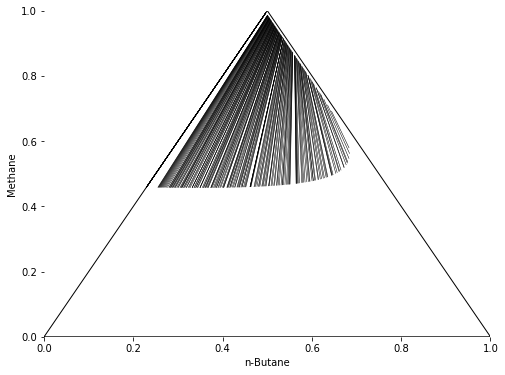

In [9]:
x, y = np.array([]), np.array([])
lx, ly = np.array([]), np.array([])
vx, vy = np.array([]), np.array([])

for m in ml:
    if m.phase == 'two-phase':
        x = np.append(x, m.Zi[1])
        y = np.append(y, m.Zi[0])
        lx = np.append(lx, m.Xi[1])
        ly = np.append(ly, m.Xi[0])
        vx = np.append(vx, m.Yi[1])
        vy = np.append(vy, m.Yi[0])

x = x + y/2
lx = lx + ly/2
vx = vx + vy/2

plt.figure(figsize=(8,6))
# plt.plot(x,y,'.')
# plt.plot(vx,vy,'.r')
# plt.plot(lx,ly,'.b')
for x1,y1,x2,y2 in zip(vx,vy,lx,ly):
    plt.plot([x1,x2],[y1,y2], '-k', linewidth=0.5)

plt.plot([0,1,1/2,0],[0,0,1,0],'-k', linewidth=1)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('n-Butane')
plt.ylabel('Methane')
plt.box(False)

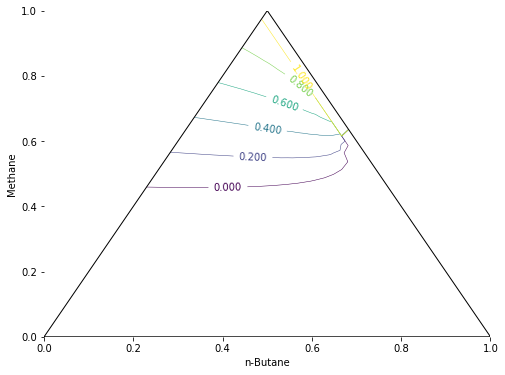

In [10]:
x, y = np.array([]), np.array([])
v = np.array([])

for m in ml:
    if ~np.isnan(m.V):
        x = np.append(x, m.Zi[1])
        y = np.append(y, m.Zi[0])
        v = np.append(v, m.V)

x = x + y/2

plt.figure(figsize=(8,6))
CS = plt.tricontour(x,y,v, np.linspace(0,1,6), linewidths=0.5)
plt.clabel(CS, inline=1, fontsize=10)
# plt.tricontourf(x,y,v, 100, cmap='jet')
# plt.tripcolor(x,y,v, cmap='hsv')
# plt.colorbar()
# plt.plot(x,y,'.b')
plt.plot([0,1,1/2,0],[0,0,1,0],'-k', linewidth=1)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('n-Butane')
plt.ylabel('Methane')
plt.box(False)

*End of notebook...*